# 컨브넷이 학습하는 내용 시각화

**저자:** [fchollet](https://twitter.com/fchollet)<br>
**만든 날짜:** 2020/05/29<br>
**최종 수정 날짜:** 2020/05/29<br>
**설명:** convnet 필터가 응답하는 시각적 패턴을 표시합니다.

## 소개

이 예제에서는 이미지 분류 모델이 어떤 종류의 시각적 패턴을 학습하는지 살펴봅니다.
ImageNet 데이터 세트에서 훈련된 'ResNet50V2' 모델을 사용할 것입니다.

프로세스는 간단합니다.
대상 레이어의 특정 필터(모델 중간 어딘가에서 선택: 레이어 `conv3_block4_out`).
이러한 이미지는 다음의 시각화를 나타냅니다.
필터가 응답하는 패턴입니다.


## 설정


In [72]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# The dimensions of our input image
img_width = 180
img_height = 180
# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
# layer_name = "conv2_block1_out"
# layer_name = "conv3_block4_out"
layer_name = "conv5_block3_out"


## 특징 추출 모델 구축


In [73]:
# Build a ResNet50V2 model loaded with pre-trained ImageNet weights
model = keras.applications.ResNet50V2(weights="imagenet", include_top=False)
print(len(model.layers))
model.summary()
# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)
# feature_extractor.summary()

190
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_16[0][0]']               
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                  

## 경사 상승 프로세스 설정

우리가 최대화할 "손실"은 단순히 대상 레이어의 특정 필터 활성화의 평균입니다.
테두리 효과를 피하기 위해 테두리 픽셀을 제외합니다.


In [74]:

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # 손실에 경계가 아닌 픽셀만 포함하여 경계 아티팩트를 방지합니다.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)



기울기 상승 기능은 단순히 입력 이미지와 관련하여 위의 손실 기울기를 계산하고 대상 필터를 더 강력하게 활성화하는 상태로 이동하도록 업데이트 이미지를 업데이트합니다.


In [75]:

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img



## 종단 간 필터 시각화 루프 설정

우리의 과정은 다음과 같습니다:

- "전체 회색"에 가까운 임의의 이미지에서 시작합니다(즉, 시각적으로 자연스러운 것).
- 위에서 정의한 기울기 상승 계단 함수를 반복적으로 적용
- 정규화, 중앙 자르기 및 [0, 255] 범위로 제한하여 결과 입력 이미지를 표시 가능한 형식으로 다시 변환합니다.


In [76]:

def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
#     print(np.min(img.numpy()))
#     print(np.max(img.numpy()))
    # [0, 1] => [-0.5,+0.5] => [-0.125, +0.125]
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

#     print(img.shape)
#     print(np.mean(img))
#     print(np.std(img))
    
    # Center crop
    img = img[25:-25, 25:-25, :]
#     print(img.shape)

    # Clip to [0, 1]
    img += 0.5
#     print(np.mean(img))
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img



In [77]:
img = initialize_image()
print(np.min(img.numpy()))
print(np.max(img.numpy()))

-0.12499985
0.1249989


In [78]:
img = visualize_filter(0)

0.5016445


대상 레이어에서 필터 0을 사용해 보겠습니다.


In [79]:
from IPython.display import Image, display

loss, img = visualize_filter(1)
keras.preprocessing.image.save_img("1.png", img)


0.4987295


대상 레이어에서 필터 0의 응답을 최대화하는 입력은 다음과 같습니다.


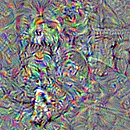

In [80]:
display(Image("1.png"))


## 대상 레이어의 처음 64개 필터를 시각화합니다.

이제 대상 레이어에서 처음 64개 필터의 8x8 그리드를 만들어 모델이 학습한 다양한 시각적 패턴의 범위를 느껴봅시다.


Processing filter 0
0.5013023
Processing filter 1
0.50011694
Processing filter 2
0.50100756
Processing filter 3
0.5012621
Processing filter 4
0.5019944
Processing filter 5
0.5000898
Processing filter 6
0.50181454
Processing filter 7
0.50041735
Processing filter 8
0.49968922
Processing filter 9
0.50083363
Processing filter 10
0.50010675
Processing filter 11
0.49958035
Processing filter 12
0.5011438
Processing filter 13
0.49959454
Processing filter 14
0.49897867
Processing filter 15
0.5000622
Processing filter 16
0.49854386
Processing filter 17
0.50061387
Processing filter 18
0.5000618
Processing filter 19
0.4995147
Processing filter 20
0.49951684
Processing filter 21
0.49832165
Processing filter 22
0.49966088
Processing filter 23
0.5005504
Processing filter 24
0.49912047
Processing filter 25
0.5007308
Processing filter 26
0.49975932
Processing filter 27
0.50156736
Processing filter 28
0.5006022
Processing filter 29
0.50277674
Processing filter 30
0.5002674
Processing filter 31
0.5002293

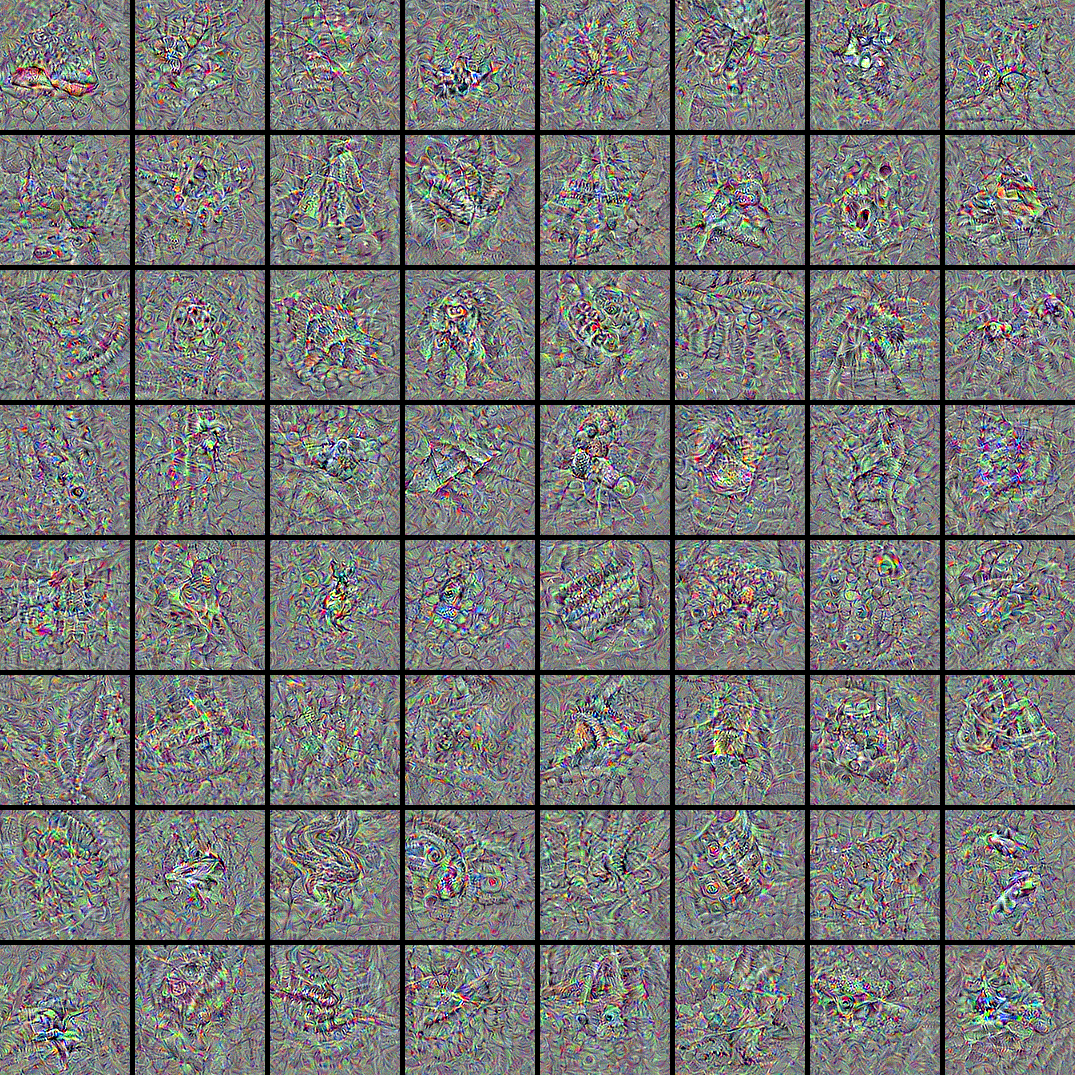

In [81]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))


이미지 분류 모델은 "벡터"를 통해 입력을 분해하여 세상을 봅니다.
이러한 텍스처 필터의 기본"입니다.

또한 보십시오
[이 오래된 블로그 포스트](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) 분석 및 해석.
